# Evaluate trained model
## Generate random weight masks during inference

In [1]:
import argparse
import os
import sys
import importlib
import inspect
import warnings
import shutil
import time
import json
import numpy as np
# import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

C:\Users\mengz\anaconda3\envs\dropnet_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
repo_path = r'C:\Users\mengz\Box\Li_Lab\DropConnect\METHODS\dropnet'
sys.path.append(repo_path)

In [3]:
from recorder import AverageMeter, ProgressMeter, Summary, Plot
from training_utils import validate

## Import Model

In [4]:
# model_name = 'DCtwoBottlenecks'
model_name = 'ResNet'
model_path = 'models'
module = importlib.import_module(f'{model_path}.{model_name}')
model_class = None

for name, obj in inspect.getmembers(module):
    if inspect.isclass(obj):
        if model_path + '.' + name == module.__name__:
            print(f'Model {module.__name__} successfully imported')
            model_class = obj

Model models.ResNet successfully imported


In [5]:
### Create model with specific size
# model_params = {'drop_prob': 0.5,
#                'out_1': 3,
#                'er_1': 6,
#                'out_2': 6,
#                'er_2': 6,}

# model_params = {'drop_prob': 0.5,
#                'out_1': 4,
#                'er_1': 6,
#                'out_2': 8,
#                'er_2': 6,}

# model = model_class(drop_probs=model_params.get('drop_prob'),
#                     out_1=model_params.get('out_1'),
#                     er_1=model_params.get('er_1'),
#                     out_2=model_params.get('out_2'),
#                     er_2=model_params.get('er_2'))

In [13]:
block_setting = [
                 [3, [{"replace_conv": [0, 0],
                       "drop_probs": [0, 0]},
                      {"replace_conv": [1, 0],
                       "drop_probs": [0.2, 0]},
                      {"replace_conv": [0, 0],
                       "drop_probs": [0, 0]},
                     ]
                  ], 
                  [3, [{"replace_conv": [0, 0],
                       "drop_probs": [0, 0]},
                      {"replace_conv": [1, 0],
                       'drop_probs': [0, 0]},
                      {"replace_conv": [0, 0],
                       "drop_probs": [0, 0]},
                     ]
                  ],
                  [3, [{"replace_conv": [0, 1],
                       "drop_probs": [0, 0]},
                      {"replace_conv": [0, 0],
                       "drop_probs": [0, 0]},
                      {"replace_conv": [0, 0],
                       "drop_probs": [0, 0]},
                     ]
                  ],
                ]

model = model_class(block_setting=block_setting)

In [7]:
### load trained model parameters
checkpoint_root_path = r'C:\Users\mengz\Box\Li_Lab\DropConnect\METHODS\dropnet\checkpoints'
model_checkpoint_folder = r'\DCtwoBottlenecks_checkpts'
model_param_folder = (f"\DCtwoBottlenecks_dr{model_params.get('drop_prob')}_out1_{model_params.get('out_1')}_er1_{model_params.get('er_1')}_" + 
                     f"out2_{model_params.get('out_2')}_er2_{model_params.get('er_2')}")
checkpoint_path = f'{checkpoint_root_path}{model_checkpoint_folder}{model_param_folder}\checkpoint.pth'
print(checkpoint_path)

if os.path.isfile(checkpoint_path):
    model_trained_state = torch.load(checkpoint_path)
else:
    print('No model checkpoint with such shape found')

if model_trained_state['arch'] == model_name:
    model.load_state_dict(model_trained_state['state_dict'])
    print('Trained model checkpoint successfully loaded')

C:\Users\mengz\Box\Li_Lab\DropConnect\METHODS\dropnet\checkpoints\DCtwoBottlenecks_checkpts\DCtwoBottlenecks_dr0.5_out1_4_er1_6_out2_8_er2_6\checkpoint.pth
Trained model checkpoint successfully loaded


## Load Data

In [8]:
# Data loading code
dataset = 'mnist'

if dataset == 'mnist':

    val_dataset = datasets.MNIST(root='data', train=False,
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]), download=True)

elif dataset == 'cifar10':
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

    val_dataset = datasets.CIFAR10(root='data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))
    
else:
    print("Dataset not supported")

In [9]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False,pin_memory=True)

## Evaluate model (inference)

In [10]:
# Validate() parameters
class val_args:
    def __init__(self, print_freq=20, gpu=None):
        self.print_freq=print_freq
        self.gpu=gpu

# define loss function (criterion)
criterion = nn.CrossEntropyLoss()

In [42]:
# acc, loss = validate(val_loader, model, criterion, val_args())
np.arange(0.1, 0.6, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5])

In [45]:
run = 20
test_results_dict = {}

for dr in np.arange(0.1, 0.6, 0.1):
    
    for r in range(run):
        print(f'-------------- Drop rate {dr} Run {r+1} --------------')
        cur_model = model_class(# drop_probs=model_params.get('drop_prob'),
                                drop_probs=dr,
                                out_1=model_params.get('out_1'),
                                er_1=model_params.get('er_1'),
                                out_2=model_params.get('out_2'),
                                er_2=model_params.get('er_2'))

        # model trained with drop rate = 50%
        cur_model.load_state_dict(model_trained_state['state_dict'])
        print('Trained model checkpoint successfully loaded')
        
        cur_acc, cur_loss = validate(val_loader, cur_model, criterion, val_args(print_freq=50))
        acc_lst.append(cur_acc.item())
        loss_lst.append(cur_loss)

    test_results_dict.update({dr: {'acc': acc_lst,
                                   'loss': loss_lst}
                             })

-------------- Run 1 --------------
Trained model checkpoint successfully loaded
Test: [ 1/79]	Time  0.063 ( 0.063)	Loss 1.2374e-01 (1.2374e-01)	Acc@1  98.44 ( 98.44)	Acc@5 100.00 (100.00)
Test: [51/79]	Time  0.052 ( 0.050)	Loss 7.0149e-02 (1.8251e-01)	Acc@1  98.44 ( 94.33)	Acc@5 100.00 ( 99.91)
-------------- Run 2 --------------
Trained model checkpoint successfully loaded
Test: [ 1/79]	Time  0.048 ( 0.048)	Loss 8.9549e-02 (8.9549e-02)	Acc@1  98.44 ( 98.44)	Acc@5 100.00 (100.00)
Test: [51/79]	Time  0.053 ( 0.050)	Loss 5.9414e-02 (1.3949e-01)	Acc@1  99.22 ( 95.91)	Acc@5 100.00 ( 99.92)
-------------- Run 3 --------------
Trained model checkpoint successfully loaded
Test: [ 1/79]	Time  0.058 ( 0.058)	Loss 1.5338e-01 (1.5338e-01)	Acc@1  93.75 ( 93.75)	Acc@5 100.00 (100.00)
Test: [51/79]	Time  0.051 ( 0.056)	Loss 8.9898e-02 (2.5499e-01)	Acc@1  99.22 ( 92.52)	Acc@5 100.00 ( 99.79)
-------------- Run 4 --------------
Trained model checkpoint successfully loaded
Test: [ 1/79]	Time  0.050 ( 

In [43]:
# model_1 = model_class(drop_probs=0.5,
#                     out_1=model_params.get('out_1'),
#                     er_1=model_params.get('er_1'),
#                     out_2=model_params.get('out_2'),
#                     er_2=model_params.get('er_2'))
# model_1.load_state_dict(model_trained_state['state_dict'])

In [44]:
# model_2 = model_class(drop_probs=0.5,
#                     out_1=model_params.get('out_1'),
#                     er_1=model_params.get('er_1'),
#                     out_2=model_params.get('out_2'),
#                     er_2=model_params.get('er_2'))
# model_2.load_state_dict(model_trained_state['state_dict'])

Text(0.5, 1.0, '\\DCtwoBottlenecks_dr0.5_out1_4_er1_6_out2_8_er2_6')

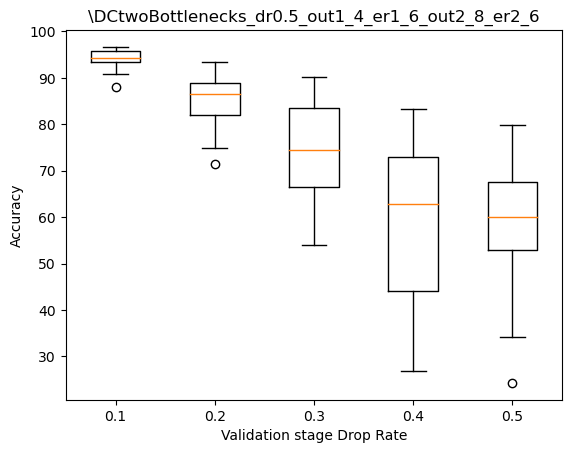

In [69]:
_ = plt.boxplot([v.get('acc') for v in test_results_dict.values()], labels=[round(k, 1) for k in test_results_dict.keys()])
plt.xlabel('Validation stage Drop Rate')
plt.ylabel('Accuracy')
plt.title(model_param_folder)